# Fit a simple kinematic model for the Milky Way disk to the OBA star proper motion data

In this model a simple circular velocity curve is fit to the proper motion data, with the following parameters:
* $V_\mathrm{circ,\odot}$ the circular velocity at the location of sun (positive by convention, in km/s)
* $dV_\mathrm{circ}/dR$ the gradient in circular velocity (km/s/kpc)
* $\mathbf{v}_{\odot,\mathrm{pec}}$ the peculiar motion vector of the sun (km/s)
* $\sigma_{xy}$ the velocity dispersion around pure circular motion of the stars in the Galactic Cartesian XY directions (2D isotropic normal)
* $\sigma_z$ the velocity dispersion around pure circular motion of the stars in the Galactic Cartesian z direction (1D normal)

Fixed parameters:
* $R_\odot$ distance from the sun to the galactic centre, assumed known from GRAVITY measurements. The value used is 8277 pc from [GRAVITY Collaboration et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...657L..12G).
* $Y_\odot$ The Galactic Cartesian Y-coordinate of the Sun, by definition 0.
* $Z_\odot$ the height of the sun above (or below) the galactic plane (pc). The value $20.8$ pc from [Bennett & Bovy (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1417B/abstract) is used. NOTE that one can introduce $Z_\odot$ as a parameter in the model below, but experiments show that the data has no constraining power on $Z_\odot$ (even if mathematically the proper motions also depend on $Z_\odot$), as the posterior distribution on the sun's height is the same as the prior.
* $\varpi_i$ parallaxes of the stars are assumed known for now (high precision subsample is used). The parallax uncertainties are thus ignored.
* Coordinates $(\ell,b)_i$, assumed error free

Observations:
* Proper motions in $\ell$ and $b$ (mas/yr)
* Proper motion covariance matrices

## Model details

The velocity $\mathbf{v}$ of a star with parallax $\varpi$ is calculated according to the following steps:

For a star at coordinates $(\ell, b)$ calculate the normal triad $[\mathbf{p}, \mathbf{q}, \mathbf{r}]$:

\begin{equation}
    \mathbf{p} = \begin{pmatrix} -\sin\ell \\ \cos\ell \\ 0 \end{pmatrix}\,,\quad
    \mathbf{q} = \begin{pmatrix} -\sin b\cos\ell \\ -\sin b\sin\ell \\ \cos b \end{pmatrix}\,,\quad
    \mathbf{r} = \begin{pmatrix} \cos b\cos\ell \\ \cos b\sin\ell \\ \sin b \end{pmatrix}\,.
\end{equation}

The calculate the Galactocentric Cartesian star position as:

\begin{equation}
    \mathbf{x} = (1000/\varpi)\mathbf{r} + \mathbf{x}_\odot\,,
\end{equation}

with $\mathbf{x}$ the $(X,Y,Z)$ position of the star. The velocity of the star is calculated from the circular velocity curve $V_\phi(R)$ as:

\begin{equation}
    \mathbf{v} = \begin{pmatrix} -V_\phi(R)\sin\phi \\ V_\phi(R)\cos\phi \\ 0 \end{pmatrix} \quad\text{with}\quad \phi=\text{atan2}(Y, X)$ \quad\text{and}\quad
    R=\sqrt{X^2+Y^2}\,.
\end{equation}

The circular velocity at the position of the star $V_\phi(R)$ is calculated as:

\begin{equation}
    V_\phi(R) = -\left(V_\mathrm{circ,\odot} + \frac{dV_\mathrm{circ}}{dR}(R-R_\odot)\right)\,.
\end{equation}

Finally the proper motions are calculated as:

\begin{equation}
    \mu_{\ell*} = \frac{\varpi}{A_\mathrm{v}}\mathbf{p}\cdot(\mathbf{v}-\mathbf{v}_\odot)\,,\quad
    \mu_b = \frac{\varpi}{A_\mathrm{v}}\mathbf{q}\cdot(\mathbf{v}-\mathbf{v}_\odot)\,,
\end{equation}

The modelling is done in a Bayesian manner with likelihood:

\begin{equation}
    \mathbf{\mu}_\mathrm{obs} \sim {\cal N}\left(\mathbf{\mu}_\mathrm{model} \mid \mathsf{D}_\mathrm{\mu} \right)\,,
\end{equation}

where the covariance matrix in the likelihood is given as:

\begin{equation}
    \mathsf{D}_\mu = \mathsf{C}_\mu + \begin{pmatrix} \mathbf{p}'\mathsf{S}\mathbf{p} & \mathbf{p}'\mathsf{S}\mathbf{q} \\
    \mathbf{q}'\mathsf{S}\mathbf{p} & \mathbf{q}'\mathsf{S}\mathbf{q}
    \end{pmatrix} (\varpi/A_\mathrm{v})^2\,,
\end{equation}

with the matrix $\mathsf{S}$ representing the velocity dispersion:

\begin{equation}
    \mathsf{S} = \begin{pmatrix}
        \sigma^2_{yx} & 0 & 0 \\
        0 & \sigma_{xy}^2 & 0 \\
        0 & 0 & \sigma_z^2
    \end{pmatrix}
\end{equation}

The model is implemented in STAN and below a choice of various models (different levels of parameter complexity can be chosen).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import ujson, os

from scipy.linalg import inv, det
from scipy.stats import multivariate_normal, chi2
from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
from astropy.visualization import HistEqStretch, ImageNormalize
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from agabpylib.plotting.plotstyles import useagab, apply_tufte
from agabpylib.stats.robuststats import rse
from pygaia.astrometry.constants import au_km_year_per_sec as Av
from pygaia.astrometry.coordinates import Transformations, CoordinateTransformation

from gala.potential.potential.builtin.special import BovyMWPotential2014
from diskkinematicmodel import *
from icrstogal import *

ct = CoordinateTransformation(Transformations.ICRS2GAL)
useagab()

/home/brown/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.0.6.patch is an invalid version and will not be supported in a future release
  warnings.warn(


## Read in the data

In [2]:
Rsun = 8277.0*u.pc

obatable = Table.read('OBA_NORR_R03_extended_redd.fits', format='fits')
obatable['parallax_over_error'] = obatable['parallax']/obatable['parallax_error']
obatable['vtan'] = (au_km_year_per_sec/obatable['parallax']*np.sqrt(obatable['pmra']**2+obatable['pmdec']**2)).value*u.km/u.s

l, b = ct.transform_sky_coordinates(np.deg2rad(obatable['ra']), np.deg2rad(obatable['dec']))
obatable['l'] = np.rad2deg(l)
obatable['b'] = np.rad2deg(b)
obatable['pml'], obatable['pmb'] = ct.transform_proper_motions(np.deg2rad(obatable['ra']), np.deg2rad(obatable['dec']), obatable['pmra'], obatable['pmdec'])
obatable['pml_error'], obatable['pmb_error'], obatable['pml_pmb_corr'] = ct.transform_proper_motion_errors(np.deg2rad(obatable['ra']), np.deg2rad(obatable['dec']),
                                                                                                           obatable['pmra_error'], obatable['pmdec_error'], 
                                                                                                           rho_muphi_mutheta=obatable['pmra_pmdec_corr'])

icrs_coords = ICRS(ra = (obatable['ra'].data*u.deg).to(u.rad),
                   dec = (obatable['dec'].data*u.deg).to(u.rad),
                   distance = (1000/obatable['parallax'].data)*u.pc,
                   pm_ra_cosdec = obatable['pmra'].data*u.mas/u.yr,
                   pm_dec = obatable['pmdec'].data*u.mas/u.yr,
                  radial_velocity = obatable['ra'].value*0.0*u.km/u.s)

galactic_coords, galactocentric_cartesian, galactocentric_cylindrical = transform_to_galactic(icrs_coords, galcendist=Rsun, sunheight=20.8*u.pc)
obatable['R_gc'] = galactocentric_cylindrical.rho

## Select a sub-sample to work with

Use a high precision parallax sample of B stars.

In [3]:
plx_snrlim = 10
vtanhalo = 180.0

startype = (obatable['spectraltype_esphs'] == 'B')
plxfilter = obatable['parallax_over_error']>plx_snrlim
nonhalo = obatable['vtan'] < vtanhalo
zmax = 250

sample_filter_init = startype & plxfilter & nonhalo & (np.abs(np.sin(np.deg2rad(obatable['b']))*1000/obatable['parallax']) < zmax)

R_filter = (obatable['R_gc']>6500.0) & (obatable['R_gc']<15000.0)

sample_filter = sample_filter_init & R_filter

print(f"Number of stars in selected sample: {obatable['ra'][sample_filter].size}")

subsample_size = 20000
if (obatable['ra'][sample_filter].size <=subsample_size):
    oba_subsample = obatable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(obatable['ra'][sample_filter].size), size=subsample_size, replace=False)
    oba_subsample = obatable[sample_filter][random_subsample]

Number of stars in selected sample: 385423


## Plot histogram of $\sin(b)\times 1000/\varpi$

Use this to estimate $Z_\odot$ for this sample.

Median d*sin(b): -16.0
RSE d*sin(b): 100.2
Mean d*sin(b): -15.2


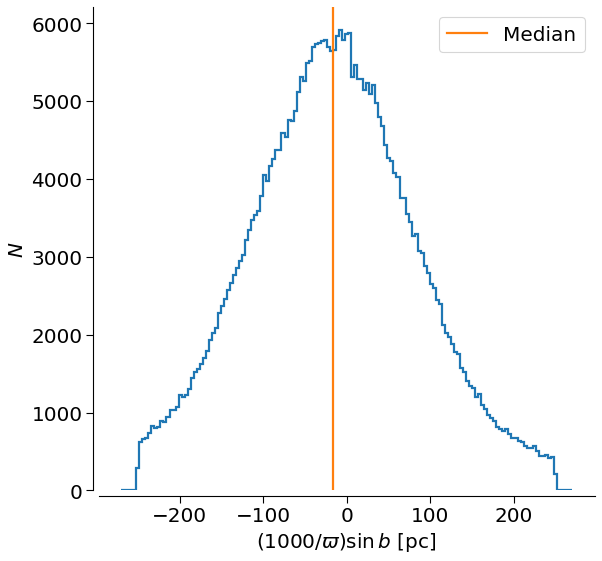

In [4]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(obatable['b']))*1000.0/obatable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-270,270])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

## Plot the sample proper motions as a function of galactic longitude

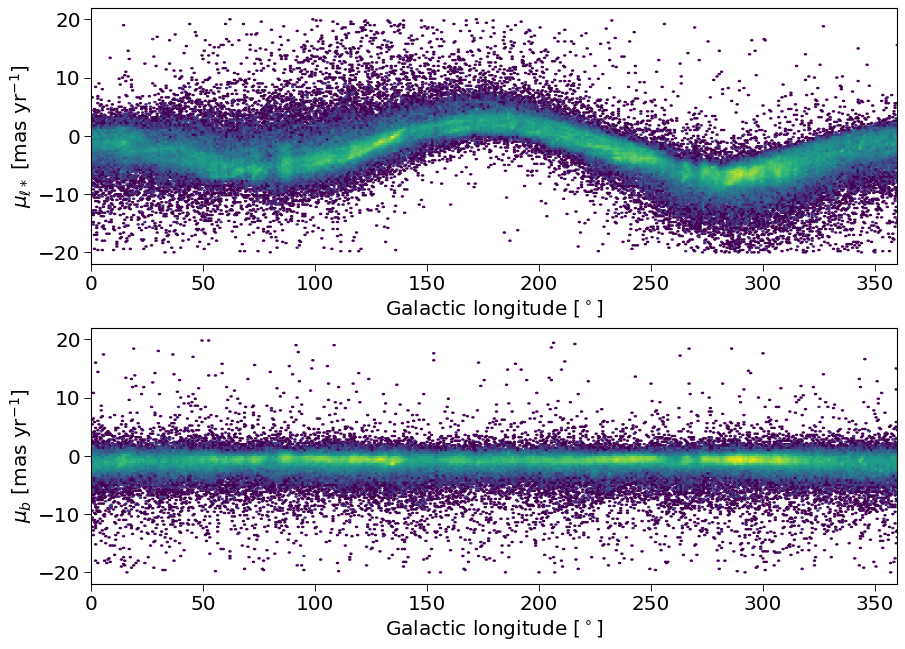

In [5]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

plt.savefig('bstar-pml-pmb-vs-galon.png')

plt.show()

## Set up the STAN model

In [6]:
nsources = oba_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

oba_data = {'N': nsources, 
            'galon': np.deg2rad(oba_subsample['l']).tolist(), 
            'galat': np.deg2rad(oba_subsample['b']).tolist(),
            'pml_obs': oba_subsample['pml'].tolist(),
            'pml_obs_unc': oba_subsample['pml_error'].tolist(),
            'pmb_obs': oba_subsample['pmb'].tolist(),
            'pmb_obs_unc': oba_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': oba_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': oba_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun':zsun.value
            }
with open('oba.data.json', 'w') as fp:
    ujson.dump(oba_data, fp)
    fp.close()
    
constant_vcirc_model = {'stanfile':'mwdisk-constant-vcirc-model.stan', 
               'npars':6,
               'parnames':['Vcirc_sun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'Zsun', 'vdisp'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$Z_\odot$', r'$\sigma_v$'], 
               'inits':{'Vcirc_sun':220.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'Zsun':20.8, 'vdisp':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'Zsun':np.nan, 'vdisp':np.nan}
              }

declining_vcirc_model = {'stanfile':'mwdisk-declining-vcirc-model.stan', 
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'Zsun', 'vdisp'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$Z_\odot$', r'$\sigma_v$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'Zsun':20.8, 'vdisp':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'Zsun':np.nan, 'vdisp':np.nan}
              }

declining_vcirc_disptens_model = {'stanfile':'mwdisk-declining-vcirc-disptens-model.stan', 
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
              }

declining_vcirc_disptens_rsunfree_model = {'stanfile':'mwdisk-declining-vcirc-disptens-rsunfree-model.stan', 
               'npars':8,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Rsun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$R_\odot$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Rsun':8.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Rsun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}
              }

stan_model = declining_vcirc_disptens_model

distsunfree = False
if stan_model['stanfile'] == 'mwdisk-declining-vcirc-disptens-rsunfree-model.stan':
    distsunfree = True

Number of sources in sample: 3000


## Sample posterior

Feed the OBA star proper motion and parallax data to the Stan model and sample the posterior for the Milky Way parameters.

In [7]:
oba_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
set_cmdstan_path(os.path.join(os.getenv('HOME'), 'cmdstan'))
oba_data_path = os.path.join(os.getcwd(), 'oba.data.json')

nwarmup = 500
nsampling = 1000
nchains = 4

oba_model = CmdStanModel(stan_file=oba_stan)
oba_fit = oba_model.sample(chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=oba_data_path, save_warmup=False, show_progress='notebook')
#oba_fit = oba_model.sample(chains=4, inits=stan_model['inits'], iter_warmup=500, iter_sampling=1000, thin=1, 
#                           data=oba_data_path, save_warmup=False, show_progress='notebook')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [8]:
oba_fit.summary()[0:stan_model['npars']+1]

Mean    MCSE  StdDev      5%     50%     95%   N_Eff  N_Eff/s  \
name                                                                          
lp__       -3700.0  0.0420    1.90 -3700.0 -3700.0 -3700.0  2000.0      6.7   
Vcirc_sun    240.0  0.0190    1.40   230.0   240.0   240.0  5200.0     17.0   
dVcirc_dVr    -3.7  0.0038    0.26    -4.1    -3.7    -3.3  4500.0     15.0   
Vsun_pec_x     7.8  0.0046    0.35     7.3     7.8     8.4  5900.0     20.0   
Vsun_pec_y    11.0  0.0065    0.45    10.0    11.0    12.0  4700.0     16.0   
Vsun_pec_z     8.3  0.0018    0.15     8.0     8.3     8.5  6300.0     21.0   
vdispxy       14.0  0.0025    0.19    14.0    14.0    15.0  5600.0     19.0   
vdispz         7.5  0.0014    0.10     7.4     7.5     7.7  5300.0     18.0   

            R_hat  
name               
lp__          1.0  
Vcirc_sun     1.0  
dVcirc_dVr    1.0  
Vsun_pec_x    1.0  
Vsun_pec_y    1.0  
Vsun_pec_z    1.0  
vdispxy       1.0  
vdispz        1.0

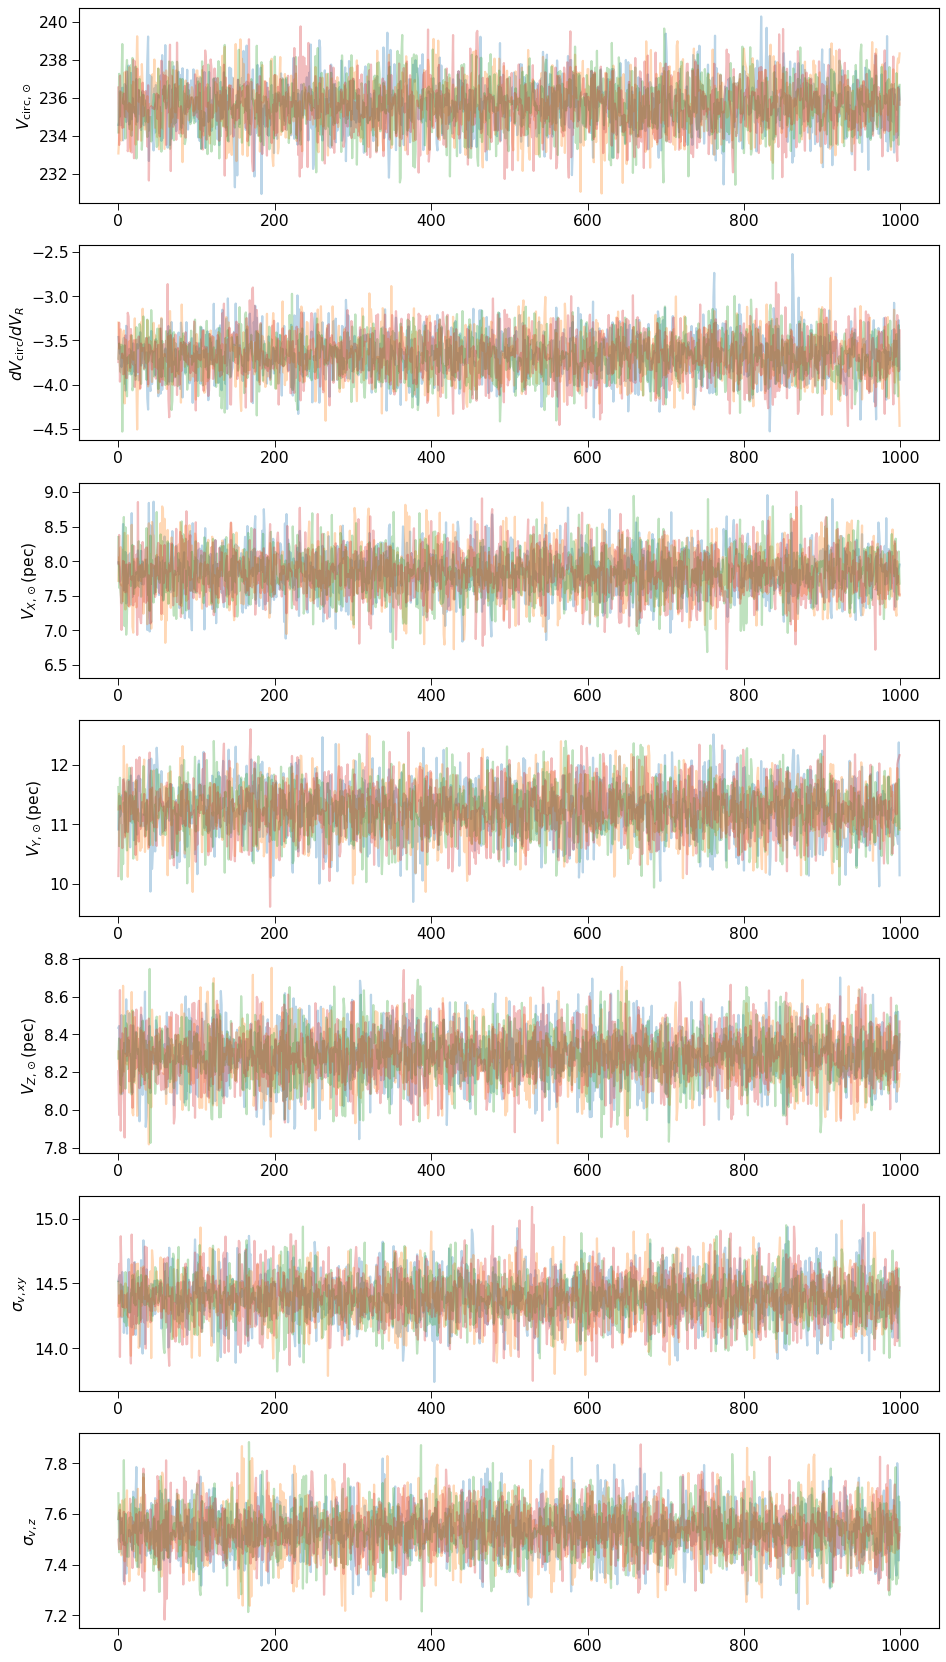

In [9]:
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

fig, axes = plt.subplots(ncols=1, nrows=stan_model['npars'], tight_layout=True, figsize=(12,3*stan_model['npars']))

for i, lab in zip(range(stan_model['npars']), stan_model['labels']):
    axes[i].plot(oba_fit.draws()[:,:,7+i], alpha=0.3)
    axes[i].set_ylabel(lab)

plt.show()

Vcirc_sun = 235.6+1.4-1.4
dVcirc_dVr = -3.7+0.3-0.3
Vsun_pec_x = 7.8+0.3-0.3
Vsun_pec_y = 11.2+0.4-0.5
Vsun_pec_z = 8.3+0.1-0.1
vdispxy = 14.4+0.2-0.2
vdispz = 7.5+0.1-0.1


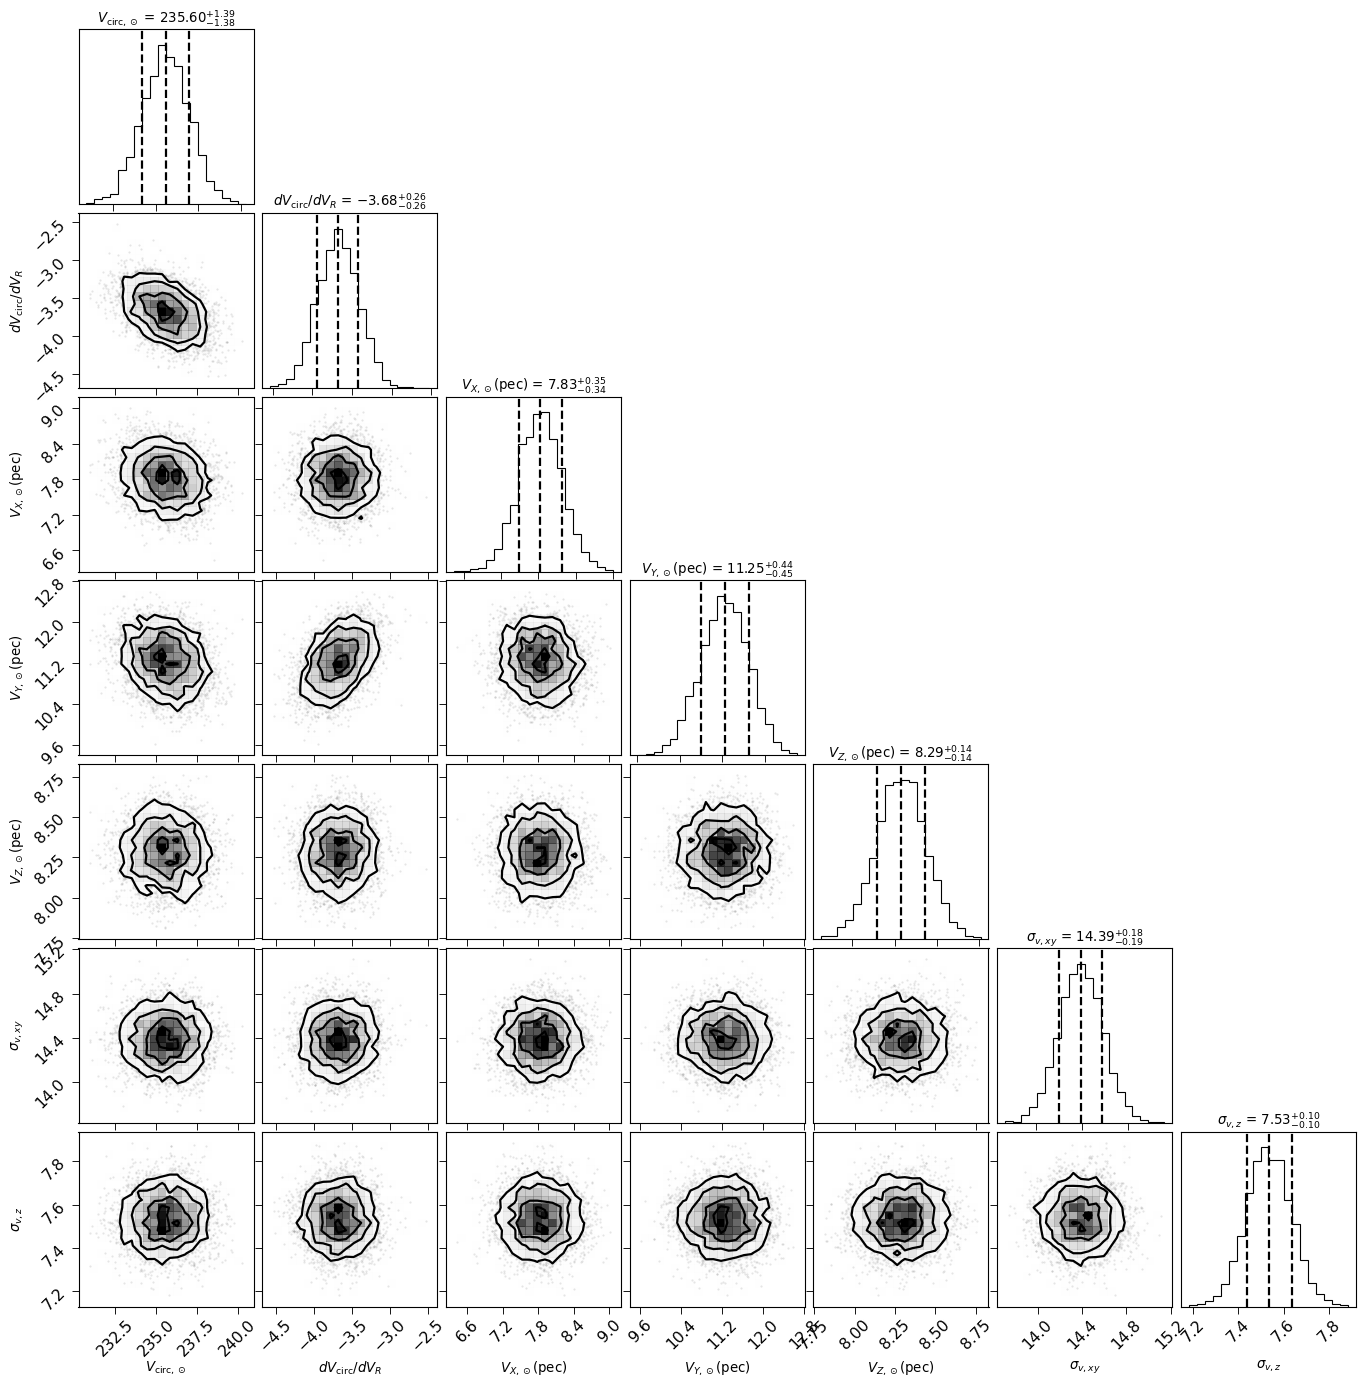

In [10]:
for par in stan_model['parnames']:
    vals = oba_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")
    
sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']):
    sample_lists.append(oba_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()
                         
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

## Sgr A* proper motion (assuming no intrinsic motion for this source) and Oort constants

In [11]:
if distsunfree:
    Rsun = stan_model['best_params']['Rsun']*1000.0*u.pc
    
vsunx_samples = oba_fit.draws()[:,:,9].flatten()
vsuny_samples = oba_fit.draws()[:,:,10].flatten()+oba_fit.draws()[:,:,7].flatten()
vsunz_samples = oba_fit.draws()[:,:,11].flatten()
vsunvec_samples = np.vstack([vsunx_samples, vsuny_samples, vsunz_samples])

vsun_circ_samples = oba_fit.draws()[:,:,7].flatten()
slope_samples = oba_fit.draws()[:,:,8].flatten()

ra_sgr = (17.0+45.0/60.0+40.0409/3600.0)*15
dec_sgr = -29 - 28.118/2300
l_sgr, b_sgr = ct.transform_sky_coordinates(np.deg2rad(ra_sgr), np.deg2rad(dec_sgr))
print(np.rad2deg(l_sgr)-360, np.rad2deg(b_sgr))

p_sgr = np.array([-np.sin(l_sgr), np.cos(l_sgr), 0.0])
q_sgr = np.array([-np.sin(b_sgr)*np.cos(l_sgr), -np.sin(b_sgr)*np.sin(l_sgr), np.cos(b_sgr)])

mu_sgr_xy_samples = -np.dot(p_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value*1000
mu_sgr_z_samples = -np.dot(q_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value*1000
mu_sgr_xy = np.median(mu_sgr_xy_samples)
mu_sgr_xy_rse = rse(mu_sgr_xy_samples)
mu_sgr_z = np.median(mu_sgr_z_samples)
mu_sgr_z_rse = rse(mu_sgr_z_samples)

print(f"mu_sgr_xy = {mu_sgr_xy:.2f}  +/- {mu_sgr_xy_rse:.3f}")
print(f"mu_sgr_z = {mu_sgr_z:.2f}  +/- {mu_sgr_z_rse:.3f}")

oortA_samples = (vsun_circ_samples/Rsun.value*1000 - slope_samples)/2
oortB_samples = (-vsun_circ_samples/Rsun.value*1000 - slope_samples)/2
oortAminB_samples = oortA_samples - oortB_samples
oortA = np.median(oortA_samples)
oortA_rse = rse(oortA_samples)
oortB = np.median(oortB_samples)
oortB_rse = rse(oortB_samples)
oortAminB = np.median(oortAminB_samples)
oortAminB_rse = rse(oortAminB_samples)

print(f"Oort A = {oortA:.2f}  +/- {oortA_rse:.3f}")
print(f"Oort B = {oortB:.2f}  +/- {oortB_rse:.3f}")
print(f"Oort A-B = {oortAminB:.2f}  +/- {oortAminB_rse:.3f}")

-5.951722261414716e-02 -0.04846468783279137
mu_sgr_xy = -6.29  +/- 0.035
mu_sgr_z = -0.21  +/- 0.004
Oort A = 16.07  +/- 0.178
Oort B = -12.39  +/- 0.120
Oort A-B = 28.46  +/- 0.166


## Model check through predictive posterior

In [12]:
idata = az.from_cmdstanpy(
    posterior=oba_fit,
    posterior_predictive=['pred_pml', 'pred_pmb'],
    observed_data={'pml_obs': oba_data['pml_obs'],
                   'pmb_obs': oba_data['pmb_obs']},
    coords={'nsources': np.arange(oba_data['N'])},
    dims={
        'pml_obs': ['nsources'],
        'pmb_obs': ['nsources'],
        'pred_pml': ['nsources'],
        'pred_pmb': ['nsources'],
    },
)

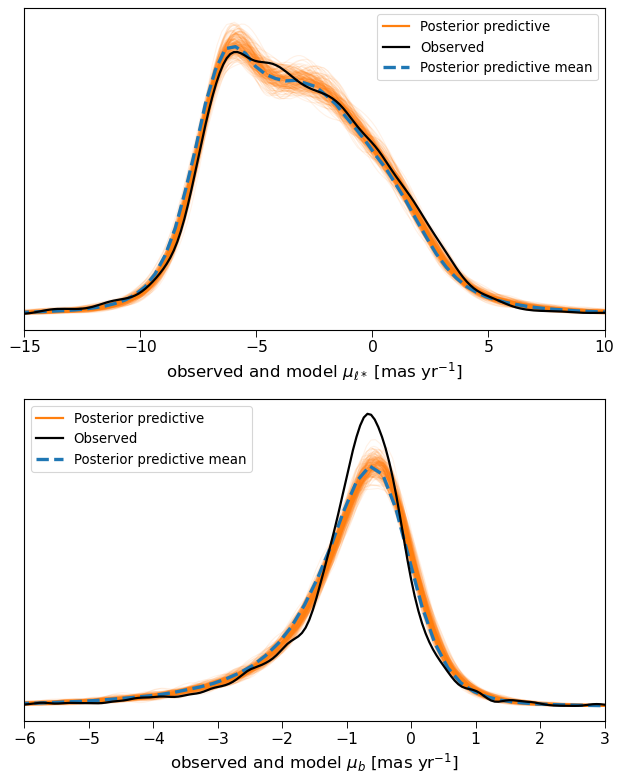

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(8, 2*5), tight_layout=True)
az.plot_ppc(idata, ax=axes, data_pairs={'pml_obs':'pred_pml', 'pmb_obs':'pred_pmb'}, 
            num_pp_samples=200, alpha=0.1, colors=['C1', 'k', 'C0'])
for ax in axes:
    ax.legend(fontsize=12)
    #apply_tufte(ax)
axes[0].set_xlim(-15,10)
axes[1].set_xlim(-6,3)
axes[0].set_xlabel(r'observed and model $\mu_{\ell*}$ [mas yr$^{-1}$]')
axes[1].set_xlabel(r'observed and model $\mu_b$ [mas yr$^{-1}$]')

plt.savefig('bstars_pms_posterior_predictive.png')

plt.show()

## Compare model predictions and observations in the proper motion vs longitude plots

In [14]:
sunpos = np.array([-Rsun.value, 0, zsun.value])*u.pc
vsunpeculiar = np.array([stan_model['best_params']['Vsun_pec_x'], stan_model['best_params']['Vsun_pec_y'], stan_model['best_params']['Vsun_pec_z']])*u.km/u.s
vcircsun = stan_model['best_params']['Vcirc_sun']
slope = stan_model['best_params']['dVcirc_dVr']

diskmodel = DiskKinematicModel(SlopedRotationCurve(vcircsun, Rsun.value, slope), sunpos, vsunpeculiar)

2.1559456645329547e+03


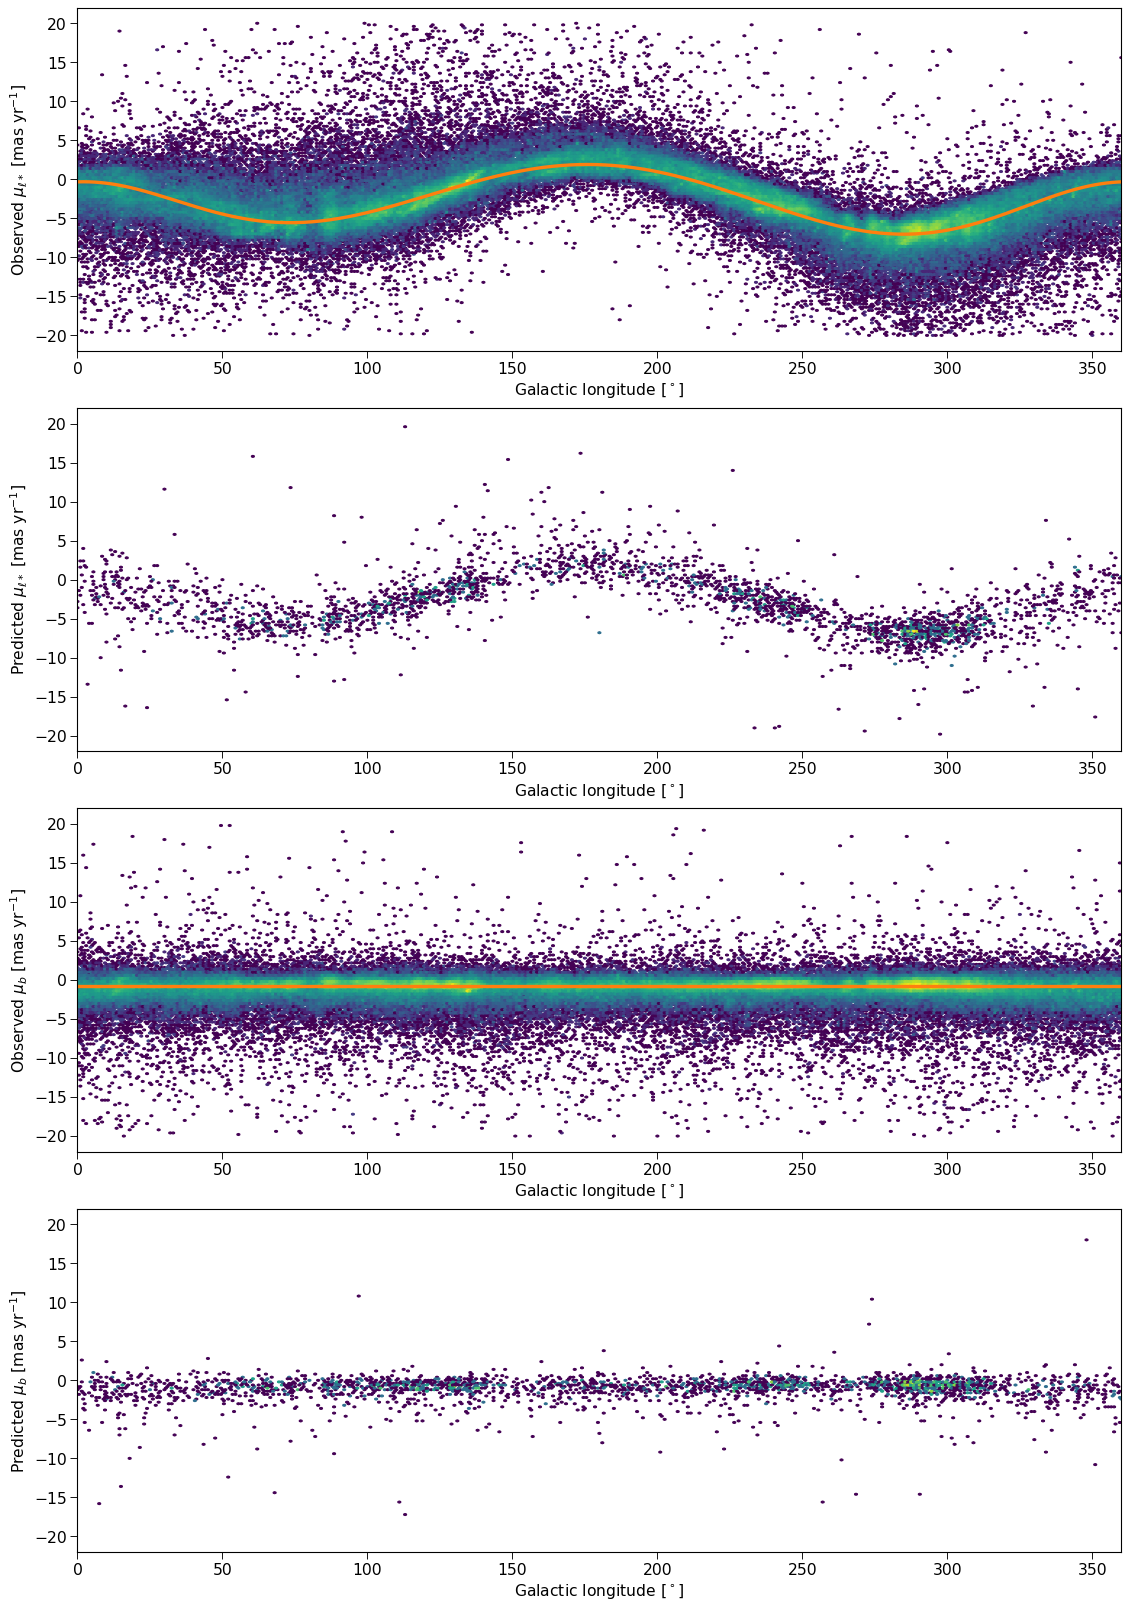

In [15]:
galon = np.linspace(0,360,361)*u.deg

median_dist = 1000/np.median(obatable['parallax'][sample_filter])
print(median_dist)

#pml_model, pmb_model, vrad_model = diskmodel_flat.observables(1000.0/obatable['parallax'][sample_filter].value*u.pc, 
#                                                              obatable['l'][sample_filter]*u.deg, obatable['b'][sample_filter]*u.deg)

chain = np.random.choice(nchains)
mcsample = np.random.choice(nsampling)

fig=plt.figure(constrained_layout=True, figsize=(14,4*5))

gs = GridSpec(4, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'Observed $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmul_model = fig.add_subplot(gs[1,0])
#im_lmul_model = ax_lmul_model.hexbin(obatable['l'][sample_filter], pml_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmul_model = ax_lmul_model.hexbin(oba_subsample['l'], idata.posterior_predictive['pred_pml'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul_model.set_ylabel(r'Predicted $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul_model.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[2,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'Observed $\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

ax_lmub_model = fig.add_subplot(gs[3,0])
#im_lmub_model = ax_lmub_model.hexbin(obatable['l'][sample_filter], pmb_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmub_model = ax_lmub_model.hexbin(oba_subsample['l'], idata.posterior_predictive['pred_pmb'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub_model.set_ylabel(r'Predicted $\mu_b$ [mas yr$^{-1}$]')
ax_lmub_model.set_xlim(0,360)

for dist in [median_dist]:
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, c='C1', lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, c='C1', lw=3)

plt.show()

## Overplot model predictions for specific distances on observed proper motions

2155.9456645329547


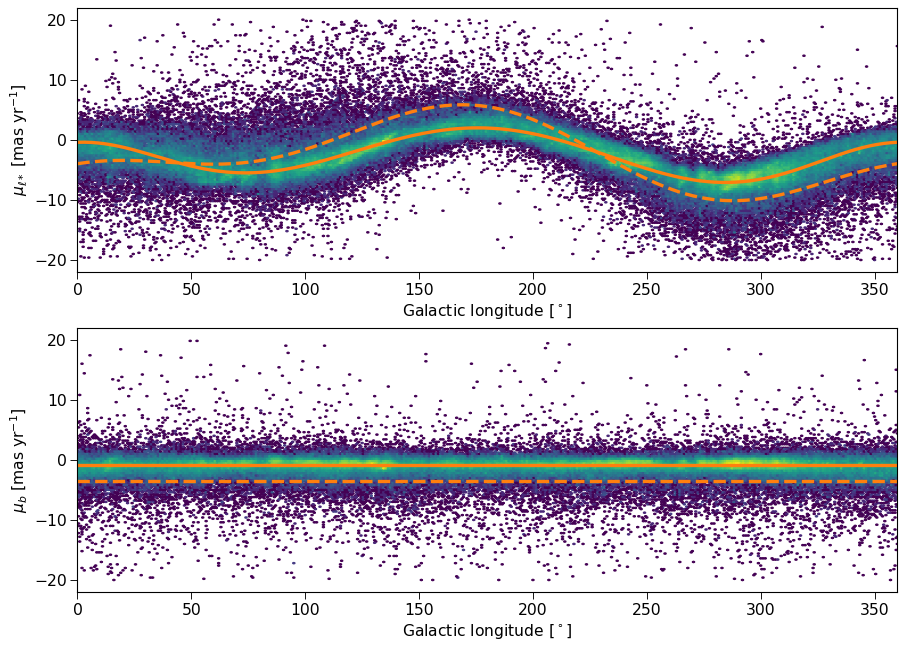

In [17]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

print(median_dist)
for dist, lstyle in zip([500, 2000], ['--C1', '-C1']):
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, lstyle, lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, lstyle, lw=3)

plt.savefig('bstar-pml-pmb-vs-galon-plusmodel.png')

plt.show()